# Demonstration for Lecture 5

Subject: Kernel-based methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Setting a random seed lets us exactly replicate our results from one run to another.
np.random.seed(333)

Same as for benign overfitting, we have:

$$
x \sim Unif(0, \pi)\\
\mu = \cos(3x)\\
y \sim N(\mu, 0.4)
$$

In [2]:
def dgp(n):
    x = np.random.uniform(low=0, high=np.pi, size = n)
    y = np.cos(3 * x) + np.random.normal(scale = 0.4, size = n)
    return x, y

def true(n):
    x = np.linspace(0, np.pi, num = n)
    y = np.cos(3 * x)
    return x, y

And we can grab our data the same way as before. We'll also pull a grid of points from the noiseless process for plotting purposes.

In [3]:
x_train, y_train = dgp(n = 60)
x_grid, y_true = true(10000)

Plot the raw data and the true function in red.

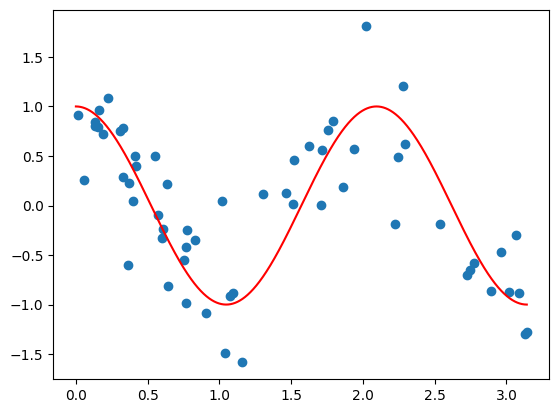

In [4]:
plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red');

We'll use the same implementation of OLS we used in the last demo.

In [5]:
def ols_predict(X, y, X_test = None, atol=1e-8):
    # Note: np.linalg.svd returns V.T, so we take the transpose to get V
    p = X.shape[1]
    n = X.shape[0]
    U, D, V = np.linalg.svd(X, full_matrices = False)
    if n > p:
        yhat = U @ U.T @ y
        if X_test is not None:
            yhat_test = X_test @ V.T @ np.diag(1 / D) @ U.T @ y
        else:
            yhat_test = None
    else:
        ok = D > atol
        Uok = U[:, ok]
        Vok = V[ok, :]
        yhat = Uok @ Uok.T @ y
        if X_test is not None:
            yhat_test = X_test @ Vok.T @ np.diag(1 / D[ok]) @ Uok.T @ y
        else:
            yhat_test = None
    return yhat, yhat_test

We're going to create a new function which calculates the implicit weights that OLS uses to construct these new predictions.

Crucially, if we think about $\tilde{X} \hat{\beta} = \tilde{X} (X^\top X)^{-1}X^\top y$ and we think about a single row of $\tilde{X}$, then calculating $\tilde{X} \hat{\beta} = \tilde{X} (X^\top X)^{-1}X^\top$ tells us the simple weighted average of $y$ we're taking to create our prediction at the new point $\tilde{X}$.

That is, for a single row $\tilde{x}$, we have
$$
\tilde{x}\hat{\beta} = \sum_i^n w_i y_i
$$
where $w_i$ is defined as
$$
w = \tilde{x} (X^\top X)^{-1}X^\top
$$

We can also write this based on the similarity between rows:

$$
\tilde{x} \hat{\beta} = \tilde{x}X^\top (XX^\top)^{-1} y
$$


In [6]:
def ols_weights(X, y, X_test = None, atol=1e-8):
    # Note: np.linalg.svd returns V.T, so we take the transpose to get V
    p = X.shape[1]
    n = X.shape[0]
    U, D, V = np.linalg.svd(X, full_matrices = False)
    if n > p:
        weight = U @ U.T
        if X_test is not None:
            weight_test = X_test @ V.T @ np.diag(1 / D) @ U.T
        else:
            weight_test = None
    else:
        ok = D > atol
        Uok = U[:, ok]
        Vok = V[ok, :]
        weight = Uok @ Uok.T @ y
        if X_test is not None:
            weight_test = X_test @ Vok.T @ np.diag(1 / D[ok]) @ Uok.T
        else:
            weight_test = None
    return weight, weight_test

In [7]:
x_test = np.array([0, 1, 2, 3])

X_train = np.hstack((np.ones((len(x_train), 1)), x_train.reshape(-1, 1)))
X_test = np.hstack((np.ones((len(x_test), 1)), x_test.reshape(-1, 1)))

In [8]:
yhat, yhat_test = ols_predict(X_train, y_train, X_test)
w_train, w_test = ols_weights(X_train, y_train, X_test)

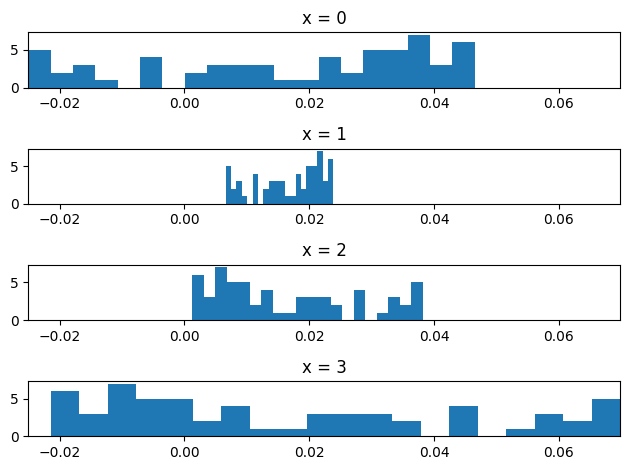

In [9]:
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].hist(w_test[i,:], bins=20)
    ax[i].set_title(f'x = {i}')
    ax[i].set_xlim(np.min(w_test), np.max(w_test))

fig.tight_layout()

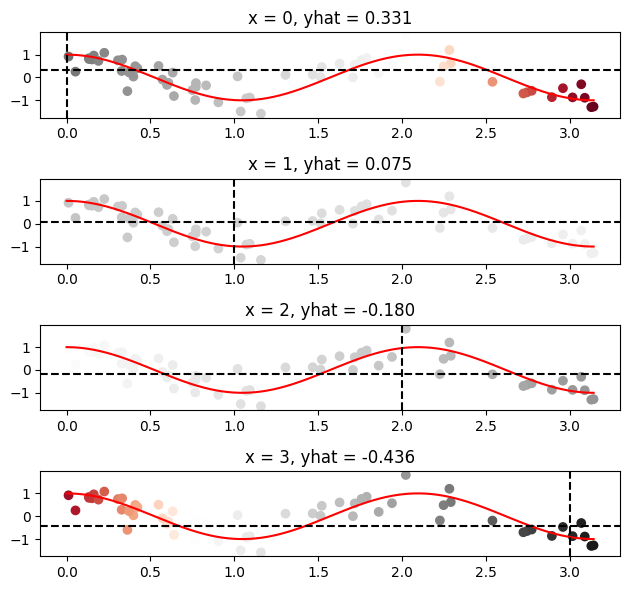

In [10]:
from matplotlib import colors

fig, ax = plt.subplots(4)
divnorm = colors.TwoSlopeNorm(vmin=np.min(w_test), vcenter=0., vmax=np.max(w_test))
for i in range(4):
    ax[i].scatter(x_train, y_train, c = w_test[i,:], cmap = "RdGy", norm = divnorm)
    ax[i].plot(x_grid, y_true, '-', color='red')
    ax[i].set_title(f'x = {i}, yhat = {yhat_test[i]:0.3f}')
    ax[i].axhline(y=yhat_test[i], linestyle="--", color="black")
    ax[i].axvline(x=i, linestyle="--", color="black")

fig.set_figheight(6)
fig.tight_layout()

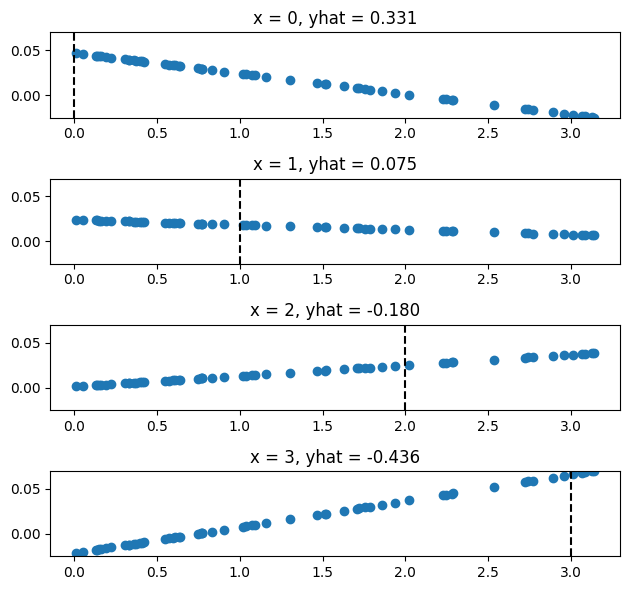

In [11]:
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].scatter(x_train, w_test[i,:])
    #ax[i].plot(x_grid, y_true, '-', color='red')
    ax[i].set_title(f'x = {i}, yhat = {yhat_test[i]:0.3f}')
    #ax[i].axhline(y=yhat_test[i], linestyle="--", color="black")
    ax[i].axvline(x=i, linestyle="--", color="black")
    ax[i].set_ylim(np.min(w_test), np.max(w_test))

fig.set_figheight(6)
fig.tight_layout()

A few things to note about the above plots
- Weights evolve linearly as the test point moves from left to right
- Points in the middle have basically equal weight on all units
- Points on the edges have very high (positive) weights on their side
- But they also have very negative weights on the opposite side

One way to think about what's going on here is that OLS assigns the center of your point cloud to the average outcome, then as you move away from it, it (linearly) assigns more weight to data on that side. Due to its restrictions on functional form, this can leave units on the opposite side of the data receiving substantial negative weights.

But there's no reason to think that the best weighting function for this is linear!

It's also natural to say that points should be a _locally_ weighted average. That is, an average of only the nearby points. The purpose of today is to showcase ways to do that.

Just to be clear, let's show what the predictions from OLS are:

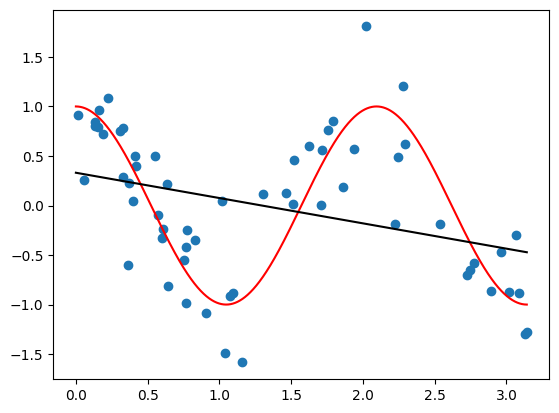

In [12]:
X_grid = np.hstack((np.ones((len(x_grid), 1)), x_grid.reshape(-1, 1)))
yhat, yhat_grid = ols_predict(X_train, y_train, X_grid)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

You can verify that the very middle of the training distribution is just an average of all labels by looking at the OLS weights for the average $x$ value:

In [13]:
x_test = np.array([np.average(x_train)])
X_test = np.hstack((np.ones((len(x_test), 1)), x_test.reshape(-1, 1)))
w_train, w_test = ols_weights(X_train, y_train, X_test)
w_test[0,:]

array([0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667])

# Problematizing our linear model

We can define a model based solely on the distance between points. We'll look at two.

Starting off, however, we need to define our kernel function. We'll use the gaussian kernel (aka the RBF)

In [14]:
def gaussian_kernel(x, y, sigma2 = 2):
    n = x.shape[0]
    m = y.shape[0]
    K = np.ones((n, m))
    for i in range(n):
        for j in range(m):
            K[i, j] = np.exp(-np.power(x[i] - y[j], 2) / 2 / sigma2)
    return K

# Kernel Ridge Regression

For this exercise, we will just calculate the solution completely explicitly, exactly like we did in the lecture.

Predictions, therefore, are just:

$$
K^* (K+\lambda I_n)^{-1} y
$$

where $K^*_{ij} = k(\tilde{x}_i, x_j)$ and $K_{ij} = k(x_i, x_j)$

In practice, you should use [sklearn.kernel_ridge.KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html).

In [15]:
def kernel_ridge_predict(x_train, y_train, x_test, lamb = 1e-5, sigma2 = 0.5):
    K_train = gaussian_kernel(x_train, x_train, sigma2 = sigma2)
    K_test = gaussian_kernel(x_test, x_train, sigma2 = sigma2)
    yhat_train = K_train @ np.linalg.inv(K_train + lamb * np.eye(K_train.shape[0])) @ y_train
    yhat_test = K_test @ np.linalg.inv(K_train + lamb * np.eye(K_train.shape[0])) @ y_train
    return yhat_train, yhat_test

def kernel_ridge_weights(x_train, y_train, x_test, lamb = 1e-5, sigma2 = 0.5):
    K_train = gaussian_kernel(x_train, x_train, sigma2 = sigma2)
    K_test = gaussian_kernel(x_test, x_train, sigma2 = sigma2)
    w_train = K_train @ np.linalg.inv(K_train + lamb * np.eye(K_train.shape[0]))
    w_test = K_test @ np.linalg.inv(K_train + lamb * np.eye(K_train.shape[0]))
    return w_train, w_test

In [16]:
x_test = np.array([0, 1, 2, 3])
X_test = np.hstack((np.ones((len(x_test), 1)), x_test.reshape(-1, 1)))

We can also verify the connection between distance and the RBF similarity measure:

In [17]:
def sq_euclidean_distance(x, y):
    n = x.shape[0]
    m = y.shape[0]
    dist = np.ones((n, m))
    for i in range(n):
        for j in range(m):
            dist[i, j] = np.power(x[i] - y[j], 2)
    return dist

In [18]:
sq_euclidean_distance(x_test, x_test), gaussian_kernel(x_test, x_test)

(array([[0., 1., 4., 9.],
        [1., 0., 1., 4.],
        [4., 1., 0., 1.],
        [9., 4., 1., 0.]]),
 array([[1.        , 0.77880078, 0.36787944, 0.10539922],
        [0.77880078, 1.        , 0.77880078, 0.36787944],
        [0.36787944, 0.77880078, 1.        , 0.77880078],
        [0.10539922, 0.36787944, 0.77880078, 1.        ]]))

In [19]:
yhat_train, yhat_test = kernel_ridge_predict(x_train, y_train, x_test, lamb = 1e-4, sigma2 = 0.5)
w_train, w_test = kernel_ridge_weights(x_train, y_train, x_test, lamb = 1e-4, sigma2 = 0.5)

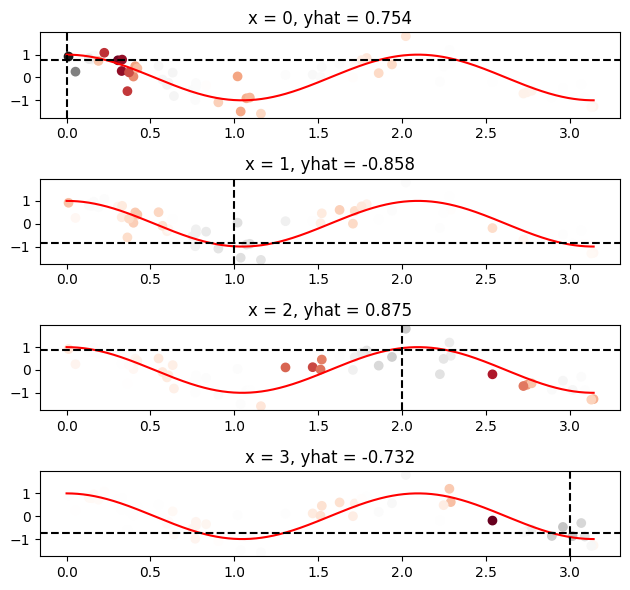

In [20]:
fig, ax = plt.subplots(4)
divnorm = colors.TwoSlopeNorm(vmin=np.min(w_test), vcenter=0., vmax=np.max(w_test))
for i in range(4):
    ax[i].scatter(x_train, y_train, c = w_test[i,:], cmap = "RdGy", norm = divnorm)
    ax[i].plot(x_grid, y_true, '-', color='red')
    ax[i].set_title(f'x = {i}, yhat = {yhat_test[i]:0.3f}')
    ax[i].axhline(y=yhat_test[i], linestyle="--", color="black")
    ax[i].axvline(x=i, linestyle="--", color="black")

fig.set_figheight(6)
fig.tight_layout()

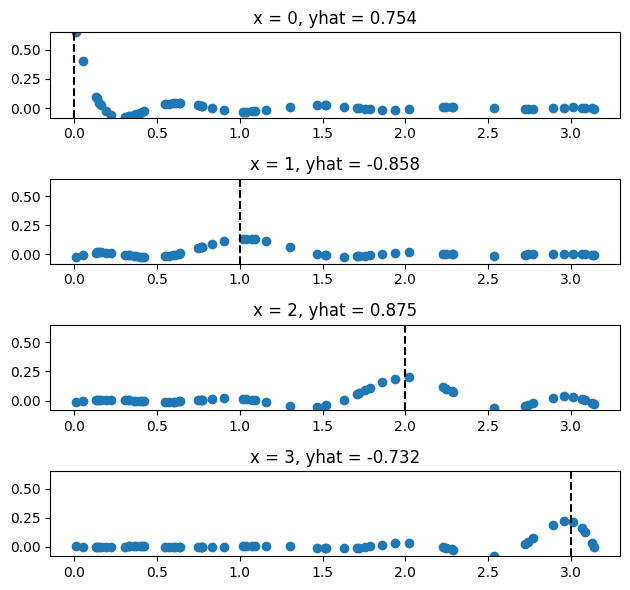

In [21]:
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].scatter(x_train, w_test[i,:])
    #ax[i].plot(x_grid, y_true, '-', color='red')
    ax[i].set_title(f'x = {i}, yhat = {yhat_test[i]:0.3f}')
    #ax[i].axhline(y=yhat_test[i], linestyle="--", color="black")
    ax[i].axvline(x=i, linestyle="--", color="black")
    ax[i].set_ylim(np.min(w_test), np.max(w_test))

fig.set_figheight(6)
fig.tight_layout()

To summarize:

Using a Gaussian kernel means that our estimates are based mostly on nearby points only (where "nearby" is defined with respect to the smooth RBF function).

We still get some weight a bit farther away from the test point, however. In general, though, we can already tell that this is much more local and flexible than what we saw with OLS.

Let's look at what kind of estimated function it gives us!

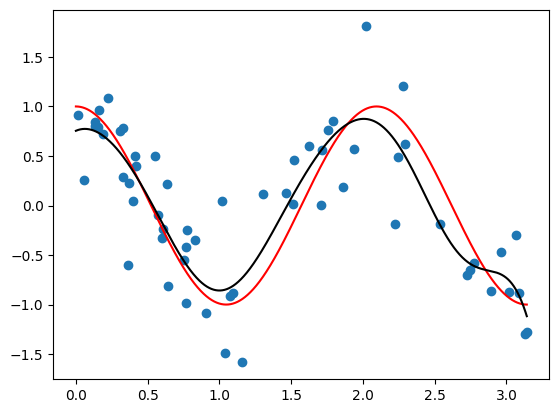

In [22]:
yhat, yhat_grid = kernel_ridge_predict(x_train, y_train, x_grid, lamb = 1e-4, sigma2 = 0.5)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

Not too bad!

But we can also make the lengthscale ($\sigma^2$) much smaller and see what happens (overfitting is what happens).

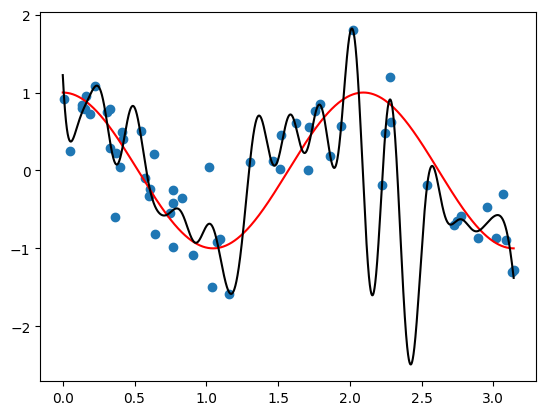

In [23]:
yhat, yhat_grid = kernel_ridge_predict(x_train, y_train, x_grid, lamb = 1e-4, sigma2 = 0.02)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

This clearly overfits to the data. Note that it's already interpolating in a lot of places. We can also crank *up* the $\sigma^2$ and observe the result:

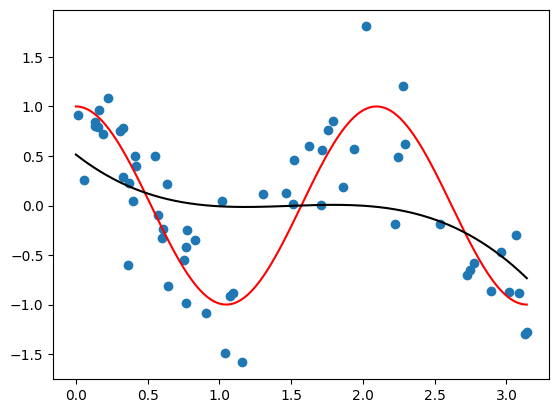

In [24]:
yhat, yhat_grid = kernel_ridge_predict(x_train, y_train, x_grid, lamb = 1e-4, sigma2 = 50)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

It's pretty clear that this underfits with a very large $\sigma^2$.

# K nearest neighbors regression

Note that this implementation doesn't technically rely on the RBF kernel to _choose_ the neighbors because the problem is one-dimensional.

We're only using the RBF kernel as the similarity weights in constructing the estimate given the set of neighbors.

You should also be aware that this is a very inefficient implementation of this algorithm. For your own work, you should use [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

In [25]:
def knnr_predict(x_train, y_train, x_test, k = 3, sigma2 = 0.5):
    K_train = gaussian_kernel(x_train, x_train, sigma2 = sigma2)
    def knn(row, k = 3):
        idx = np.argpartition(row, -k)[-k:]
        sim = row[idx]
        row = np.zeros(row.shape)
        # Take the similarity-weighted average of neighbors
        row[idx] = sim / np.sum(sim)
        return row

    K_train = np.apply_along_axis(knn, 1, K_train, k = k)
    
    K_test = gaussian_kernel(x_test, x_train, sigma2 = sigma2)
    K_test = np.apply_along_axis(knn, 1, K_test, k = k)

    yhat_train = K_train @ y_train
    yhat_test = K_test @ y_train
    return yhat_train, yhat_test

def knnr_weights(x_train, y_train, x_test, k = 3, sigma2 = 0.5):
    K_train = gaussian_kernel(x_train, x_train, sigma2 = sigma2)
    def knn(row, k = 3):
        idx = np.argpartition(row, -k)[-k:]
        sim = row[idx]
        row = np.zeros(row.shape)
        row[idx] = sim / np.sum(sim)
        return row

    K_train = np.apply_along_axis(knn, 1, K_train, k = k)
    
    K_test = gaussian_kernel(x_test, x_train, sigma2 = sigma2)
    K_test = np.apply_along_axis(knn, 1, K_test, k = k)

    return K_train, K_test

In [26]:
yhat_train, yhat_test = knnr_predict(x_train, y_train, x_test, k = 5, sigma2 = 1)
w_train, w_test = knnr_weights(x_train, y_train, x_test, k = 5, sigma2 = 1)

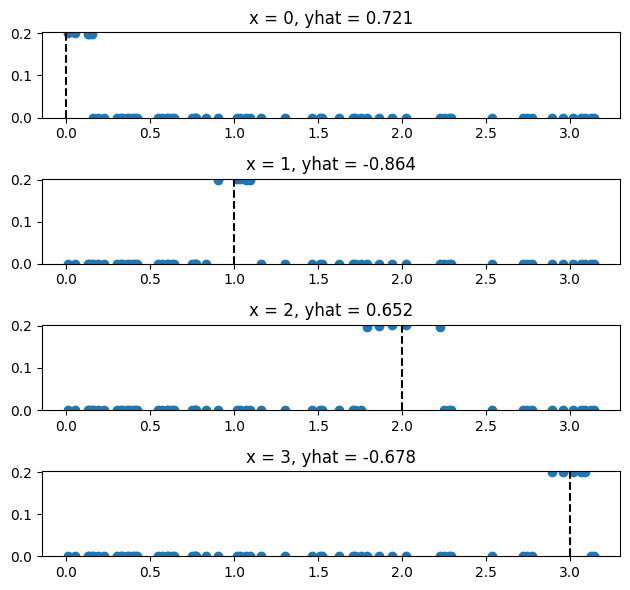

In [27]:
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].scatter(x_train, w_test[i,:])
    #ax[i].plot(x_grid, y_true, '-', color='red')
    ax[i].set_title(f'x = {i}, yhat = {yhat_test[i]:0.3f}')
    #ax[i].axhline(y=yhat_test[i], linestyle="--", color="black")
    ax[i].axvline(x=i, linestyle="--", color="black")
    ax[i].set_ylim(np.min(w_test), np.max(w_test))

fig.set_figheight(6)
fig.tight_layout()

We can see clearly that the weighting function is extremely local. We can also see that since the similarity is high for all of the nearby points, it ends up being pretty much equivalent to a uniform weighting over the $k$ nearby points.

Next, let's take a look at what the resulting estimated function looks like:

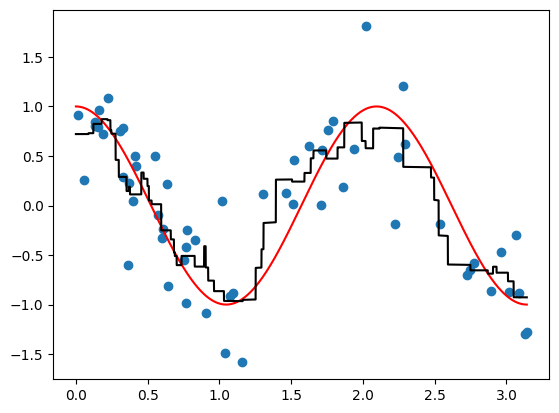

In [28]:
yhat, yhat_grid = knnr_predict(x_train, y_train, x_grid, k = 5, sigma2 = 1)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

Pretty good! We can also use a higher value of $k$ and see what happens (underfitting happens).

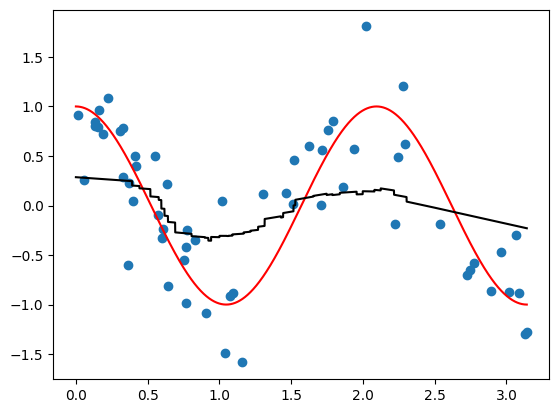

In [29]:
yhat, yhat_grid = knnr_predict(x_train, y_train, x_grid, k = 25, sigma2 = 1)

plt.scatter(x_train, y_train)
plt.plot(x_grid, y_true, '-', color='red')
plt.plot(x_grid, yhat_grid, '-', color='black');

Both Kernel Ridge Regression and KNN regression can be extremely flexible, but as you can see based on these examples, tuning their hyperparameters is very important.

This notebooks doesn't work through how to cross-validate appropriately, but you will see this in your lab this week. By this point, you shouldn't be surprised that this will be important!